# GO enrichment - Granja et al.
We used GREAT (4.0.4) to run GO enrichment analysis of selectively accessible and inaccessible regions.

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import random
import scanpy as sc
from sklearn.preprocessing import binarize
from SEMITONES.support_funcs import sig_dictionary
from SEMITONES.support_funcs import sig_bool
from SEMITONES.enrichment_scoring import sig_interval

In [2]:
adata = ad.read_h5ad("../raw/scATAC-Healthy-Hematopoiesis-191120-adata")
umap2 = np.genfromtxt('../processed/Granja_ATAC_umap2.csv', delimiter=',')
umap25 = np.genfromtxt('../processed/Granja_ATAC_umap25.csv', delimiter=',')

In [3]:
ann = pd.read_csv('../processed/Granja_ATAC_anno.txt', sep='\t', index_col=0)
ann.sort_index(inplace=True)
ann.reset_index(drop=True, inplace=True)

In [4]:
escores = pd.read_hdf('../processed/Granja_ATAC_escore.h5', 'escores')
pscores = pd.read_hdf('../processed/Granja_ATAC_pscore.h5', 'pscores')

In [5]:
interval = sig_interval(pscores, n_sds=10)
sigdict_acc = sig_dictionary(escores, interval, sign='positive')
sigdict_inacc = sig_dictionary(escores, interval, sign='negative')
sigdict = sig_dictionary(escores, interval)

In [6]:
ct_ctname = {'01_HSC':'HSC',
             '02_Early.Eryth':'Early Erythroid Cell',
             '03_Late.Eryth':'Late Erythroid Cell',
             '04_Early.Baso':'Early Basophil',
             '05_CMP.LMPP':'CMP/LMPP',
             '06_CLP.1':'CLP 1',
             '07_GMP':'GMP',
             '08_GMP.Neut':'GMP/Nertrophil',
             '09_pDC':'pDC',
             '10_cDC':'cDC',
             '11_CD14.Mono.1':'CD14 Monocyte 1',
             '12_CD14.Mono.2':'CD14 Monocyte 2',
             '13_Unk':'Unknown',
             '14_Unk':'Unknown',
             '15_CLP.2':'CLP 2',
             '16_Pre.B':'Pre B Cell',
             '17_B':'B cell',
             '18_Plasma':'Plasma Cell',
             '19_CD8.N':'CD8+ Naive T Cell',
             '20_CD4.N1':'CD4+ Naive T Cell 1',
             '21_CD4.N2':'CD4+ Naive T Cell 2',
             '22_CD4.M':'CD4+ Memory T Cell',
             '23_CD8.EM':'CD8+ Effector T Cell',
             '24_CD8.CM':'CD8+ Central Memory T Cell',
             '25_NK':'NK cell',
             '26_Unk':'Unknown'}

In [7]:
rcell_ct = {}
for rcell in sigdict_acc:
    rcell_ct[rcell] = adata.obs['BioClassification'][rcell]

In [8]:
bg_bed = pd.read_csv('../processed/Granja_ATAC_bed.bed', sep='\t',header=None)

First, we saved the selectively accessible and inaccessible regions of each reference cell as bed files.

In [16]:
def make_bed(bg_bed, sigdict, acc=None, typ='regions'):
    
    prom_set = set(np.where(ann['Annotation'].str.contains('promoter').fillna(False))[0])
    
    try:
        os.mkdir('../processed/Granja/{}_{}'.format(acc, typ))
    except:
        pass

    for i in range(5):
        dir = '../processed/Granja/{}_{}{}'.format(acc,typ,i)
        try:
            os.mkdir(dir)
        except:
            pass

        for f in os.listdir(dir):
            os.remove(os.path.join(dir, f))

        nstart = 0+i*20
        nend = 20+i*20
        rcells = escores.columns[nstart:nend]


        for rc in rcells:
            if typ=='prom':
                feat_id = list(prom_set.intersection(set(sigdict[rc])))
                df=bg_bed.loc[feat_id,:]
            else:
                df=bg_bed.loc[sigdict[rc],:]
            
            # in the same folder for GO
            df.to_csv('../processed/Granja/{}_{}/{}.bed'.format(acc,typ,rc),header=None,index=None,sep='\t')

In [17]:
# make beds for all regions
make_bed(bg_bed, sigdict_acc, acc='acc', typ='regions')
make_bed(bg_bed, sigdict_inacc, acc='inacc', typ='regions')

Perform GO enrichment by running Granja_GREAT.R.

In [13]:
# summarize results
def get_great_psumdf(acc='acc'):
    ts = []
    for rcell in sigdict_acc:
    #rcell=21887
        try:
            res = pd.read_csv('../Granja/GREAT/{}{}.tsv'.format(acc,rcell),sep='\t')
        except:
            continue

        res.set_index('name', inplace=True)
        
        s=res['Hyper_Adjp_BH']
        s.name = int(rcell)
        ts.append(s)
    
    
    psumdf = pd.concat(ts, axis=1)
    # to include all rcells
    template_df = pd.DataFrame(columns=[int(x) for x in sigdict_acc])
    psumdf = pd.concat([template_df,psumdf]).fillna(1)
    psumdf = -np.log10(psumdf).replace({-np.inf:np.nan})
    psumdf = psumdf.fillna(np.max(np.max(psumdf)))
    #change rcells into cell types
    psumdf.set_axis(adata.obs['BioClassification'][psumdf.columns],axis=1,inplace=True)
    psumdf.index.name = 'name'
    psumdf.columns.name = None
    
    return psumdf

In [14]:
psum_acc = get_great_psumdf(acc='acc')
psum_inacc = get_great_psumdf(acc='inacc')

/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/hliou/miniconda3/envs/mtproject/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


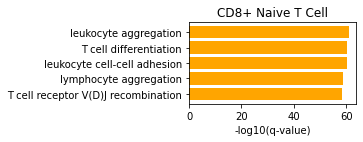

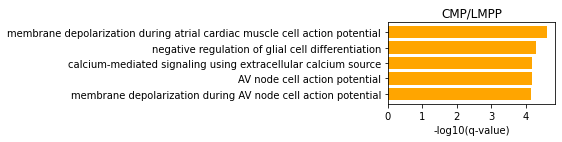

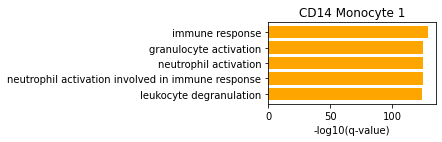

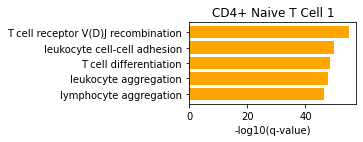

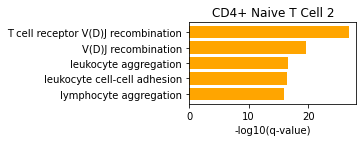

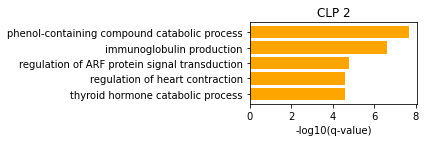

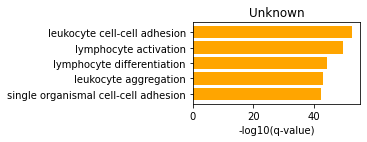

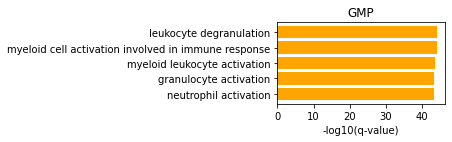

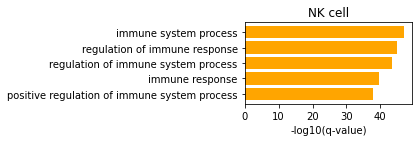

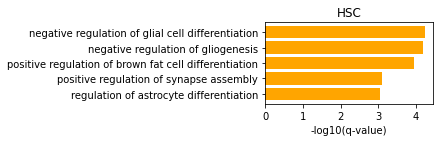

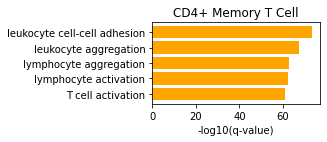

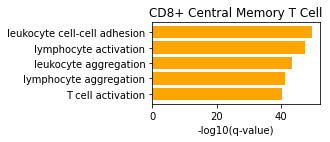

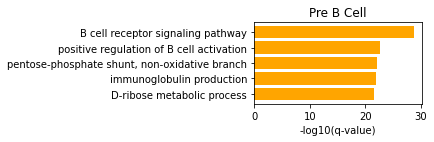

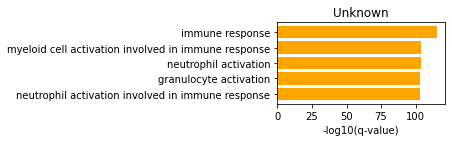

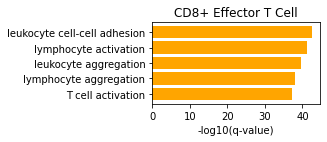

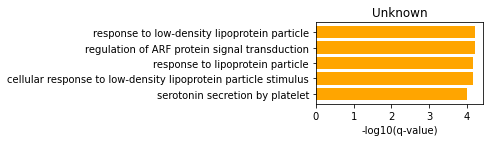

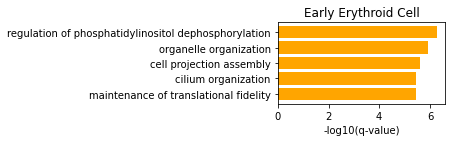

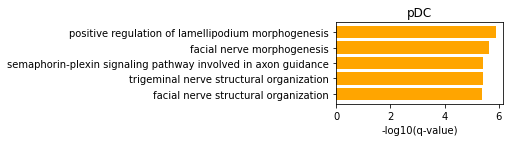

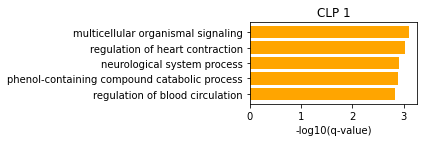

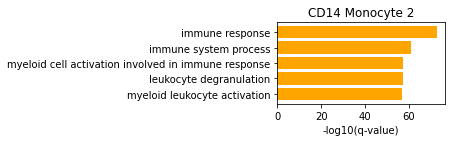

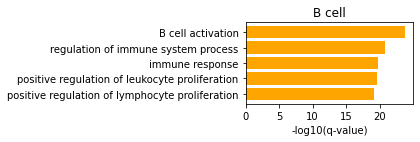

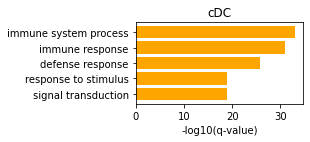

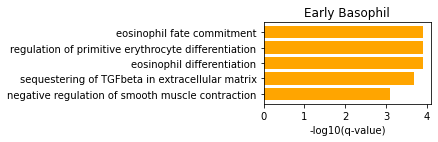

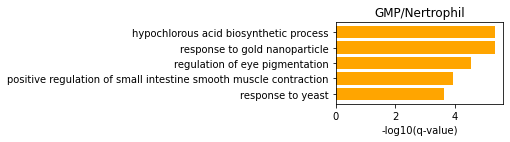

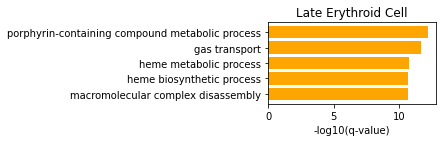

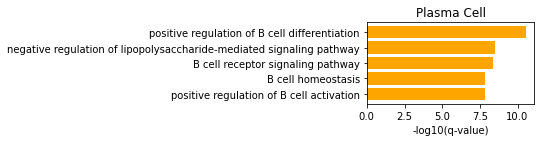

In [15]:
# GO enrichment of selectively accessible regions
for ct in psum_acc.columns.unique():

    if len(psum_acc[ct].shape)==1:
        top = psum_acc[ct].sort_values(ascending=False)[:5]
    else:
        top = psum_acc[ct].mean(axis=1).sort_values(ascending=False)[:5]
    top.sort_values(inplace=True)

    plt.figure(figsize=(3,1.5))
    plt.barh(top.index,top, color="orange")
    plt.title('{}'.format(ct_ctname[ct]))
    plt.xlabel('-log10(q-value)')
    plt.show()

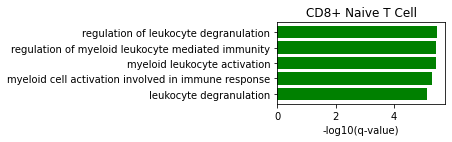

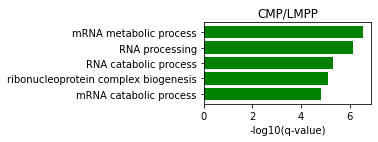

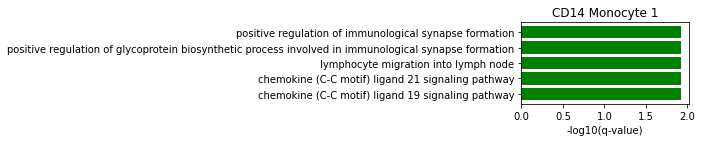

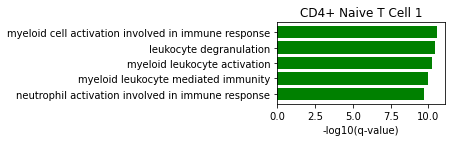

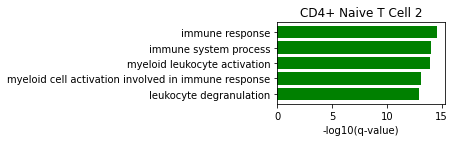

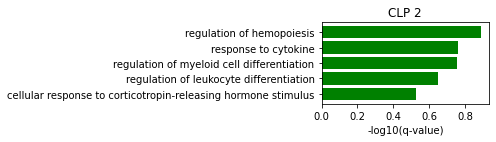

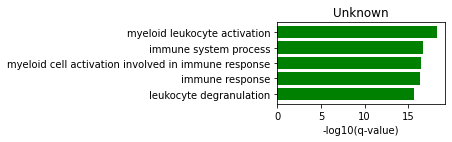

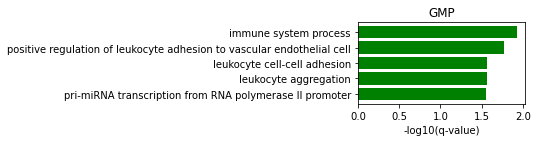

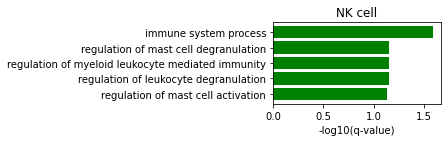

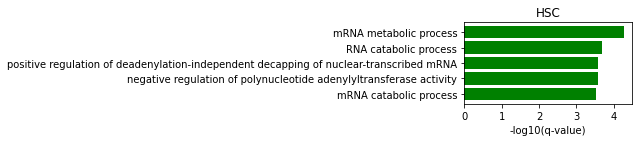

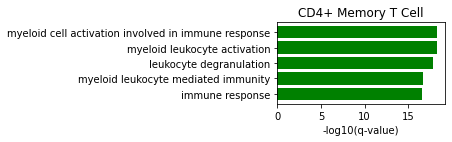

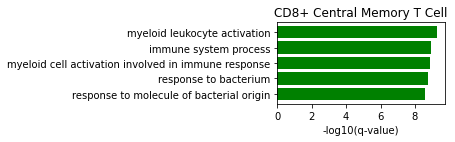

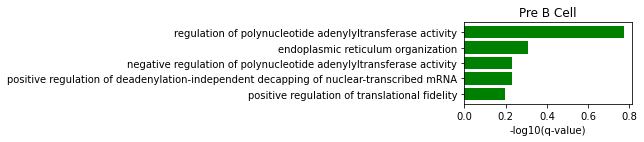

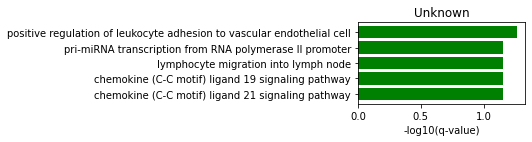

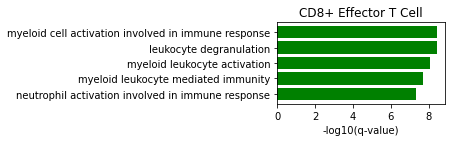

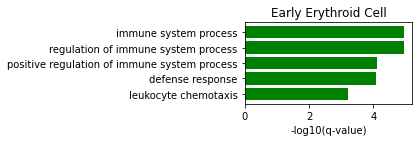

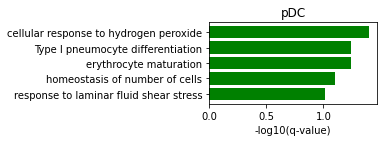

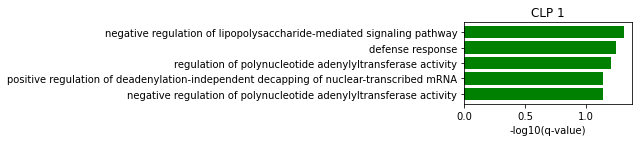

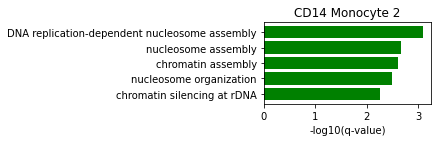

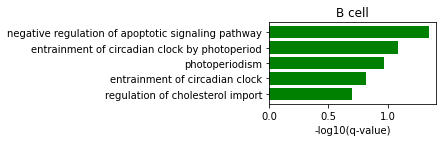

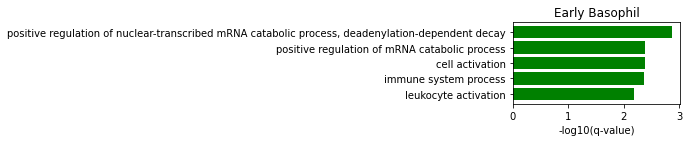

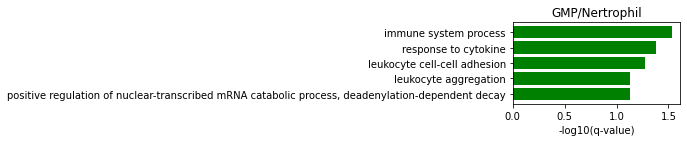

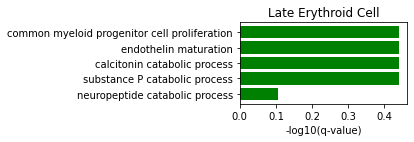

In [24]:
# GO enrichment of selectively inaccessible regions
for ct in psum_acc.columns.unique():
    #ct = '19_CD8.N'
    if len(psum_inacc[ct].shape)==1:
        top = psum_inacc[ct].sort_values(ascending=False)[:5]
    else:
        top = psum_inacc[ct].mean(axis=1).sort_values(ascending=False)[:5]
    if top.sum() == 0:
        continue
    top.sort_values(inplace=True)

    plt.figure(figsize=(3,1.5))
    plt.barh(top.index,top, color="green")
    plt.title('{}'.format(ct_ctname[ct]))
    plt.xlabel('-log10(q-value)')
    plt.show()